# NH3 Alignment Procedure

A visualization of the alignment procedure for the NH3 molecular structure.

1. Data projection onto the point cloud
2. Convex Hull
3. Minimal subgraph structures (3)
4. Alignment of subgraph structure

In [1]:
from abc import ABCMeta
import ast

import torch
import numpy as np

import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('../pyorbit/utils')
from alignment3D import *
from qhull import Qhull
from geometry import *
from hopcroft import *

In [8]:
'''
Rewrite everything to do visualization .-.

'''

def build_adjacency_list(edges):
    adj_list = {}
    for edge in edges:
        a, b = edge
        if a not in adj_list:
            adj_list[a] = []
        if b not in adj_list:
            adj_list[b] = []
        adj_list[a].append(b)
        adj_list[b].append(a)
    return adj_list

def get_key(dct, value):
    keys = []
    for key, val in dct.items():
        if val == value:
            keys.append(key)
    return keys

def direct_graph(edges):
    dg = []
    for edge in edges:
        dg.append(list(edge))
        dg.append(list(edge[::-1]))
    return dg

def custom_round(number, tolerance):
    k = int(-np.log10(tolerance))
    return round(number, k)

def list_rotate(lst):
    idx = lst.index(min(lst))
    return lst[idx:] + lst[:idx]

class Molecule:
    def __init__(self, data=None, cat_data=None):
        self.pos = data
        self.z = cat_data

class Frame(metaclass=ABCMeta):
    def __init__(self, tol=1e-2, *args, **kwargs):
        super().__init__()
        self.tol = tol
        self.chull = Qhull()


    def align(self, data, shell_data, cat_data, pth):
        fig = plt.figure(tight_layout=True)
        ax = fig.add_subplot(111, projection='3d')
        plot_data(ax, data, shell_data, pth)
        plt.savefig('./base_data.pdf',format='pdf',bbox_inches='tight')
        plt.show()
        plt.close()
        
        funcs = {0: z_axis_alignment, 1: zy_planar_alignment, 2: sign_alignment}
        for idx,val in enumerate(pth):
            data, rot = funcs[idx](data, shell_data[val])
            shell_data, rot = funcs[idx](shell_data, shell_data[val])

            
            fig = plt.figure(tight_layout=True)
            ax = fig.add_subplot(111, projection='3d')
            plot_data(ax, data, shell_data, pth)
            plt.savefig(f'./alignment_{idx}.pdf',format='pdf',bbox_inches='tight')
            plt.show()
            plt.close()
        
        return data, shell_data

    def traverse(self, sorted_graph, shell_data, shell_rank):
        edge = 0
        v0 = sorted_graph[edge][0][0]
        if shell_rank == 1:
            return [v0]
        s0 = shell_data[v0]

        v1 = None
        while v1 is None and edge < len(sorted_graph):
            possible_indices = sorted_graph[edge][1]
            possible_indices = [i for i in possible_indices if i != v0]
            for idx in possible_indices:
                if np.abs(np.dot(s0, shell_data[idx])) > self.tol:
                    v1 = idx
                    break
            if v1 is None:
                edge += 1

        if shell_rank == 2:
            return [v0, v1]

        v2 = self.v2_subroutine(v0, v1, edge, sorted_graph, shell_data, shell_rank)
        if v2 is None:
            v2 = self.v2_subroutine(v1, v0, edge, sorted_graph, shell_data, shell_rank)
        
        assert v2 is not None, 'v2 is None'

        return [v0, v1, v2]

    def v2_subroutine(self, v0, v1, edge, sorted_graph, shell_data, shell_rank):
        s0 = shell_data[v0]
        s1 = shell_data[v1]
        v2 = None
        while v2 is None and edge < len(sorted_graph):
            if v1 in sorted_graph[edge][0]:
                possible_indices = sorted_graph[edge][1]
                possible_indices = [i for i in possible_indices if i != v0]
                possible_indices = [i for i in possible_indices if i != v1]
                for idx in possible_indices:
                    cond1 = np.abs(np.dot(s0, shell_data[idx])) > self.tol
                    cond2 = np.abs(np.dot(s1, shell_data[idx])) > self.tol
                    if cond1 and cond2:
                        v2 = idx
                        break
            if v2 is None:
                edge += 1
        return v2


    def convert_partition(self, dist_hash, g_hash, r_encoding, g_encoding):
        edges = list(tuple(ast.literal_eval(k)) for k in self.hopcroft._partition.keys())
        ret_edges = []
        ret_graph = []
        for edge in edges:
            a,b = edge
            r0 = get_key(dist_hash, a[0])
            g0 = get_key(g_hash, a[1])
            r1 = get_key(dist_hash, b[0])
            g1 = get_key(g_hash, b[1])
            ret_edges.append([(r0,g0),(r1,g1)])
            r0 = get_key(r_encoding, a[0])
            r1 = get_key(r_encoding, b[0])
            ret_graph.append([r0,r1])

        indexed_edges = sorted(enumerate(ret_edges), key=lambda x: x[1])
        sorted_inidces = [i for i,_ in indexed_edges]
        ret_edges = [element for index, element in indexed_edges]
        ret_graph = [ret_graph[i] for i in sorted_inidces]
        return sorted(ret_edges), ret_graph


    def construct_dfa(self, encoding, graph):
        dfa_encoding = {}
        dfa_set = list()
        for i,edge in enumerate(graph):
            value = str([encoding[edge[0]], encoding[edge[1]]])
            dfa_encoding[(edge[0], edge[1])] = (value, i)
            dfa_set.append(value)
        return dfa_set, dfa_encoding

    def align_center(self, pointcloud):
        return pointcloud - np.mean(pointcloud,axis=0)


    def geometric_encoding(self, shell_data, adj_list, shell_rank):
        # Project edges onto relative plane
        encoding = {}
        g_hash = {}
        for point in adj_list.keys():
            r_ij = shell_data[adj_list[point]]-shell_data[point]
            if shell_rank == 1:
                d_ij = np.zeros_like(np.linalg.norm(r_ij, axis=1))
            else:
                d_ij = np.linalg.norm(r_ij, axis=1)
            projection = project_onto_plane(r_ij, shell_data[point])
            angle = []
            for i in range(len(projection)):
                if shell_rank == 3:
                    angle += [angle_between_vectors(projection[i], projection[i-1])]
                else:
                    angle += [0]

            # lexicographical shift
            lst = [(custom_round(a,self.tol),custom_round(d,self.tol)) for a,d in zip(angle, d_ij)]
            lst = tuple(list_rotate(lst))
            if lst not in g_hash:
                g_hash[lst] = id(lst)
            encoding[point] = g_hash[lst]
        return g_hash, encoding


    def check_type(self, data, *args, **kwargs):
        if isinstance(data, torch.Tensor):
            return data.detach().cpu().numpy()
        elif isinstance(data, np.ndarray):
            return data
        else:
            raise TypeError(f"Data type not supported {type(data)}")


    def project_sphere(self, data, cat_data, *args, **kwargs):
        distances = np.linalg.norm(data, axis=1, keepdims=False)
        temp =  data/np.linalg.norm(data, axis=1, keepdims=True)
        arr, key = np.unique(temp, axis=0, return_inverse=True)
        encoding = {}
        dists_hash = {}
        for val in set(key):
            dists = [(custom_round(d,self.tol), custom_round(c,self.tol))  for d,c in zip(distances[key==val],cat_data[key==val])]
            dists = tuple(sorted(dists))
            if dists not in dists_hash:
                dists_hash[dists] = id(dists)

            encoding[val] = dists_hash[dists]
        return dists_hash, encoding, arr


    def get_frame(self, data, cat_data, *args, **kwargs):

        data = self.check_type(data) # Assert Type
        data = self.align_center(data) # Assert Centered
        indices = np.linalg.norm(data, axis=1) > self.tol
        original_data = data.copy()
        original_cat = cat_data.copy()
        data = data[indices]
        cat_data = cat_data[indices]
        
        # PROJECT ONTO SPHERE
        dist_hash, r_encoding, shell_data = self.project_sphere(data, cat_data, *args, **kwargs)

        
        # GET CONVEX HULL
        shell_rank = np.linalg.matrix_rank(shell_data, tol=self.tol)
        shell_n = shell_data.shape[0]
        shell_graph = self.chull.get_chull_graph(shell_data, shell_rank, shell_n)


        bool_lst = [i in shell_graph for i in range(shell_n)]
        if not all(bool_lst):
            false_values = [i for i, x in enumerate(bool_lst) if not x]
            shell_data = np.delete(shell_data, false_values, axis=0)
            # PROJECT ONTO SPHERE
            dist_hash, r_encoding, shell_data = self.project_sphere(shell_data, *args, **kwargs)
            cat_hash, cat_encoding = self.categorical_encoding(data, cat_data)
            
            # GET CONVEX HULL
            shell_rank = np.linalg.matrix_rank(shell_data, tol=self.tol)
            shell_n = shell_data.shape[0]
            shell_graph = self.chull.get_chull_graph(shell_data, shell_rank, shell_n)

        bool_lst = [i in shell_graph for i in range(shell_n)]
        assert all(bool_lst), 'Convex Hull is not correct'

        # GET GEOMETRIC ENCODING
        adj_list = build_adjacency_list(shell_graph)
        dg = direct_graph(shell_graph)
        g_hash, g_encoding = self.geometric_encoding(shell_data, adj_list, shell_rank)

        # COMBINE ENCODINGS
        n_encoding = {}
        # for each node combine ENCODINGS
        for i in range(shell_n):
            n_encoding[i] = (r_encoding[i], g_encoding[i])

        # CONSTRUCT DFA
        dfa, edge_encoding = self.construct_dfa(n_encoding, dg)
        self.hopcroft = PartitionRefinement(dfa)
        out = self.hopcroft.refine(dfa)

        sorted_edges, sorted_graph = self.convert_partition(dist_hash, g_hash, r_encoding, g_encoding)
        pth = self.traverse(sorted_graph, shell_data, shell_rank)
        # data, shell_data = self.align(data, shell_data, cat_data, pth)
                
        fig = plt.figure(tight_layout=True)
        ax = fig.add_subplot(111, projection='3d')
        plot_projection(ax, data, cat_data, shell_data)
        plt.savefig(f'./projection.pdf',format='pdf',bbox_inches='tight')
        plt.show()
        plt.close()

                
        fig = plt.figure(tight_layout=True)
        ax = fig.add_subplot(111, projection='3d')
        plot_projection(ax, data, cat_data, shell_data, edges=shell_graph)
        plt.savefig(f'./graph.pdf',format='pdf',bbox_inches='tight')
        plt.show()
        plt.close()

        k_lst = [0,2,3]
        for idx,k in enumerate(k_lst):
            cycle = [[1,k],[k,k_lst[idx-1]],[k_lst[idx-1],1]]
                            
            fig = plt.figure(tight_layout=True)
            ax = fig.add_subplot(111, projection='3d')
            plot_projection(ax, data, cat_data, shell_data, edges=shell_graph, cycle=cycle)
            plt.savefig(f'./cycle_{idx}.pdf',format='pdf',bbox_inches='tight')
            plt.show()
            plt.close()

        data, shell_data = self.align(data, shell_data, cat_data, pth)

        
        return data

In [43]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(1)

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (16,9)
plt.rcParams["font.size"] = 50
plt.rcParams["font.family"] = 'serif'
plt.rcParams['mathtext.default'] = 'default'
# plt.rcParams["font.weight"] = 'bold'
plt.rcParams["xtick.color"] = 'black'
plt.rcParams["ytick.color"] = 'black'
plt.rcParams["axes.edgecolor"] = 'black'
plt.rcParams["axes.linewidth"] = 1

from scipy.spatial.transform import Rotation as R


#-----------------------------------------------------------------------------------------------------------------------------------------------------
# Init
#-----------------------------------------------------------------------------------------------------------------------------------------------------

def plot_projection(ax, data, cat_data, shell_data, edges=[], cycle=[]):

        
    AZIM=70
    ELEV=30
    L_THC = 16
    L_OP = .3
    P_THC = 2000
    P_OP = .4
    V_THC = 10
    V_OP = .1
    AR_LEN=0.2
    AX_LEN=0.
    AX_WTH=10
    AX_STY='_x'

    LIM = 0.7
    ax.set_axis_off()
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.set_xlim([-LIM,LIM])
    ax.set_ylim([-LIM,LIM])
    ax.set_zlim([-LIM+.2*LIM,LIM-.2*LIM])

    origin = [0,0,0]
    x = [-1,0,0]
    y = [0,1,0]
    z = [0,0,1]
    ax.quiver(origin[0], origin[1], origin[2], x[0], x[1], x[2], color='k', linewidth=AX_WTH, arrow_length_ratio=AX_LEN)
    ax.quiver(origin[0], origin[1], origin[2], y[0], y[1], y[2], color='k', linewidth=AX_WTH, arrow_length_ratio=AX_LEN)
    ax.quiver(origin[0], origin[1], origin[2], z[0], z[1], z[2], color='k', linewidth=AX_WTH, arrow_length_ratio=AX_LEN)
    
    ax.view_init(elev=ELEV, azim=AZIM)
    ax.shade = True
    
    # Surface
    
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))
    surf = ax.plot_surface(x, y, z, cmap=cm.Greys_r, alpha=.03, linewidth=.1, edgecolor='k')
    
    # Plane
    r = 1
    center = (0, 0, 0)
    phi = np.linspace(0, np.pi, 100)
    theta = np.linspace(0, 2 * np.pi, 100)
    x = r * np.outer(np.cos(theta), np.sin(phi)) + center[0]
    y = r * np.outer(np.sin(theta), np.sin(phi)) + center[1]
    z = r * np.outer(np.ones(np.size(theta)), np.cos(phi)) + center[2]
    plt.contour(x, y, z, [0], colors='grey')


    for edge in edges:
        x0,y0,z0=shell_data[edge[0]]
        x1,y1,z1=shell_data[edge[1]]
        ax.plot([x0, x1], [y0, y1], [z0, z1], color='grey', alpha=1, linewidth=L_THC)  # You can choose any color
        
    for edge in cycle:
        x0,y0,z0=shell_data[edge[0]]
        x1,y1,z1=shell_data[edge[1]]
        ax.quiver(x0, y0, z0, x1-x0, y1-y0, z1-z0, color='b', alpha=1.0, arrow_length_ratio=AR_LEN, linewidth=L_THC)    # x0,y0,z0=center, center, center
        # ax.plot([x0, x1], [y0, y1], [z0, z1], color='blue', alpha=1, linewidth=L_THC)  # You can choose any color  
   
    colors = {1:'k', 6:'b', 7:'g'}
    # Data
    # for i,point in enumerate(data):
    #     ax.scatter(point[0], point[1], point[2], color=colors[cat_data[i]], alpha=1.0, s=P_THC/2)
    cat_data = [1, 7, 1, 1]
    for i,point in enumerate(shell_data):
        ax.scatter(point[0], point[1], point[2], color=colors[cat_data[i]], alpha=1.0, s=P_THC)
        
    if AX_STY=='_x':
        ax.text(-1., 0.0, -.15, "$z$", color='k')
        ax.text(-.02, 1.0, -.15, "$y$", color='k')
        ax.text(-.1, 0, .98, "$x$", color='k')



def plot_data(ax, data, shell_data, pth):

    AZIM=70
    ELEV=30
    L_THC = 16
    L_OP = .3
    P_THC = 2000
    P_OP = .4
    V_THC = 10
    V_OP = .1
    AX_LEN=0.
    AX_WTH=10
    AX_STY='_x'

    LIM = 0.7
    ax.set_axis_off()
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.set_xlim([-LIM,LIM])
    ax.set_ylim([-LIM,LIM])
    ax.set_zlim([-LIM+.2*LIM,LIM-.2*LIM])

    origin = [0,0,0]
    x = [1,0,0]
    y = [0,1,0]
    z = [0,0,1]
    ax.quiver(origin[0], origin[1], origin[2], x[0], x[1], x[2], color='k', linewidth=AX_WTH, arrow_length_ratio=AX_LEN)
    ax.quiver(origin[0], origin[1], origin[2], y[0], y[1], y[2], color='k', linewidth=AX_WTH, arrow_length_ratio=AX_LEN)
    ax.quiver(origin[0], origin[1], origin[2], z[0], z[1], z[2], color='k', linewidth=AX_WTH, arrow_length_ratio=AX_LEN)
    
    ax.view_init(elev=ELEV, azim=AZIM)
    ax.shade = True
    
    # Surface
    
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))
    surf = ax.plot_surface(x, y, z, cmap=cm.Greys_r, alpha=.03, linewidth=.1, edgecolor='k')

    cat_data = [7,1,1,1]
    # Plane
    r = 1
    center = (0, 0, 0)
    phi = np.linspace(0, np.pi, 100)
    theta = np.linspace(0, 2 * np.pi, 100)
    x = r * np.outer(np.cos(theta), np.sin(phi)) + center[0]
    y = r * np.outer(np.sin(theta), np.sin(phi)) + center[1]
    z = r * np.outer(np.ones(np.size(theta)), np.cos(phi)) + center[2]
    plt.contour(x, y, z, [0], colors='grey')

    cycle = [[1,0],[0,2]]
    # Data
    # for point in data:
    #     ax.scatter(point[0], point[1], point[2], color='k', alpha=1.0, s=P_THC)
    invert_pth = [i for i in range(shell_data.shape[0]) if i not in pth]
    for point in shell_data[invert_pth]:
        ax.scatter(point[0], point[1], point[2], color='grey', alpha=1.0, s=P_THC)
    colors = ['b','r','g']
    color_dict = {1:'k', 7:'g'}
    for i,key in enumerate(pth):
        point = shell_data[key]
        ax.scatter(point[0], point[1], point[2], color=color_dict[cat_data[i]], alpha=1.0, s=P_THC)
        
    for edge in cycle:
        point0 = shell_data[edge[0]]
        point1 = shell_data[edge[1]]
        dx = point1[0] - point0[0]
        dy = point1[1] - point0[1]
        dz = point1[2] - point0[2]
        # ax.plot([x0, x1], [y0, y1], [z0, z1], color='blue', alpha=1, linewidth=L_THC)  # You can choose any color  
        ax.quiver(point0[0], point0[1], point0[2], dx, dy, dz, color='b', alpha=1.0, arrow_length_ratio=.2, linewidth=L_THC)    # x0,y0,z0=center, center, center
    # x1,y1,z1=data[0],data[1],data[2]
    # ax.quiver(x0, y0, z0, x1, y1, z1, color=['r','b','g'], arrow_length_ratio=0, linewidth=V_THC)
    
    
    if AX_STY=='_x':
        ax.text(1.18, 0.0, .05, "$y$", color='k')
        ax.text(-.0, 1., -.15, "$z$", color='k')
        ax.text(-.09, 0, .78, "$x$", color='k')

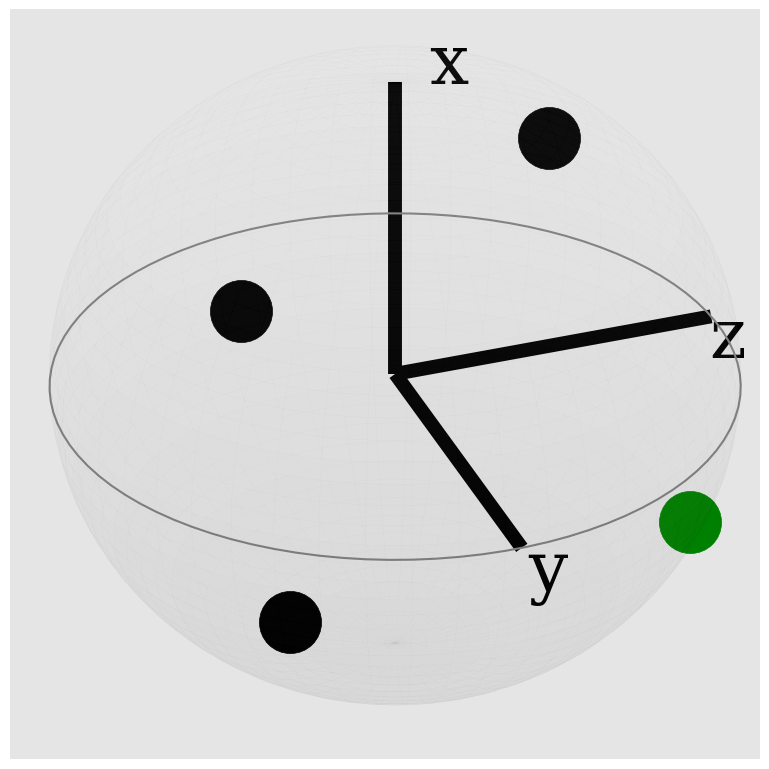

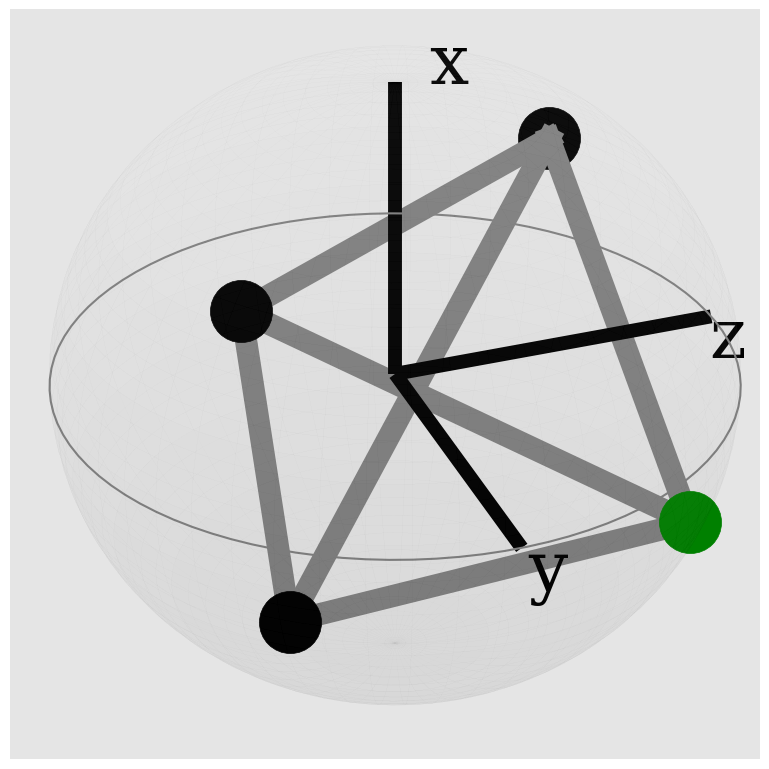

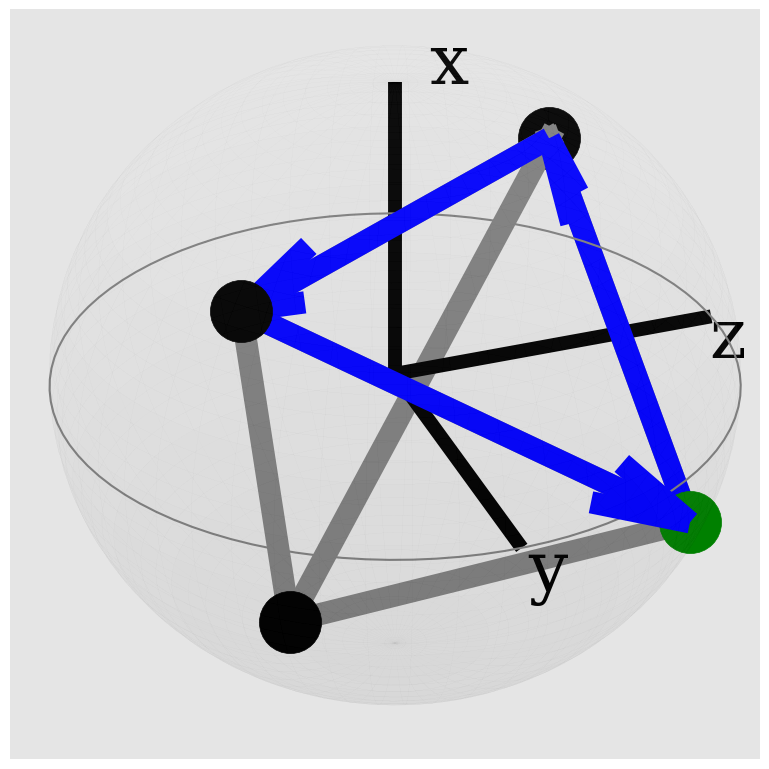

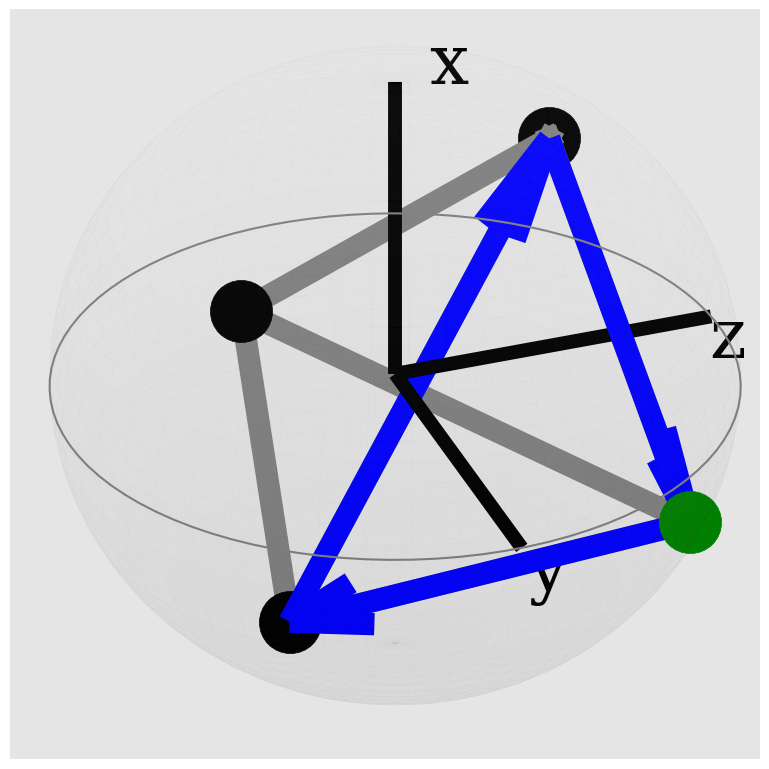

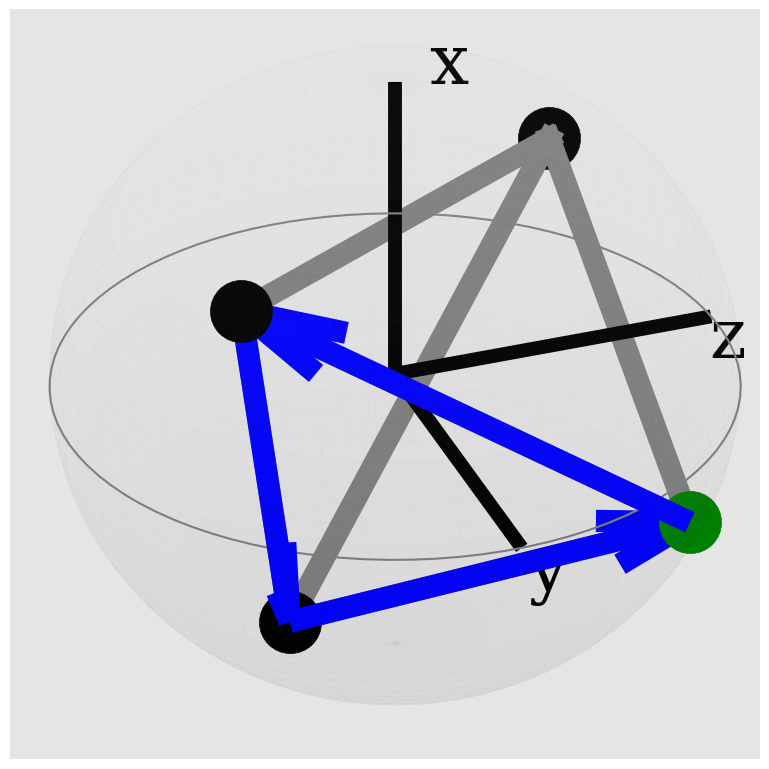

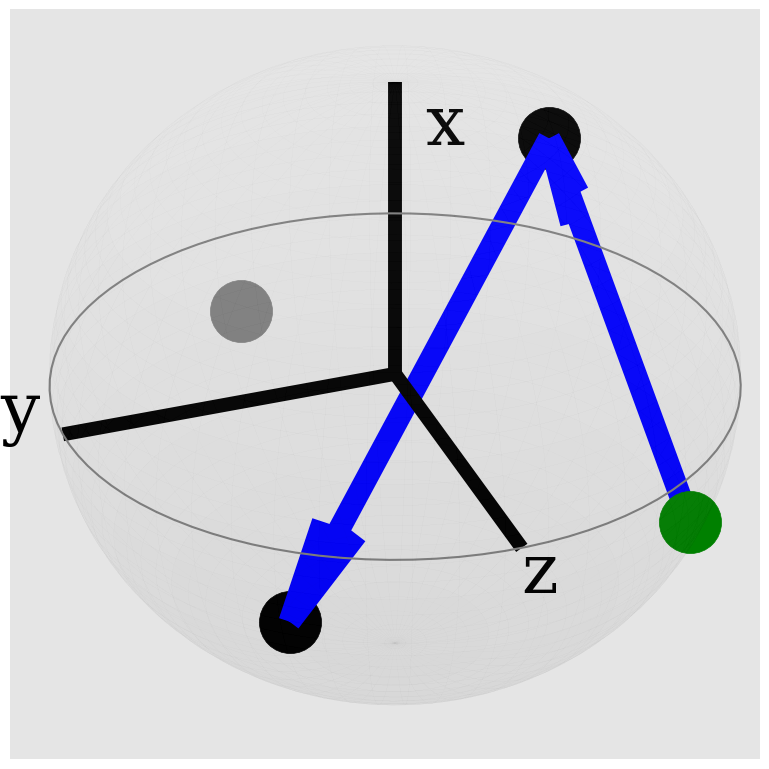

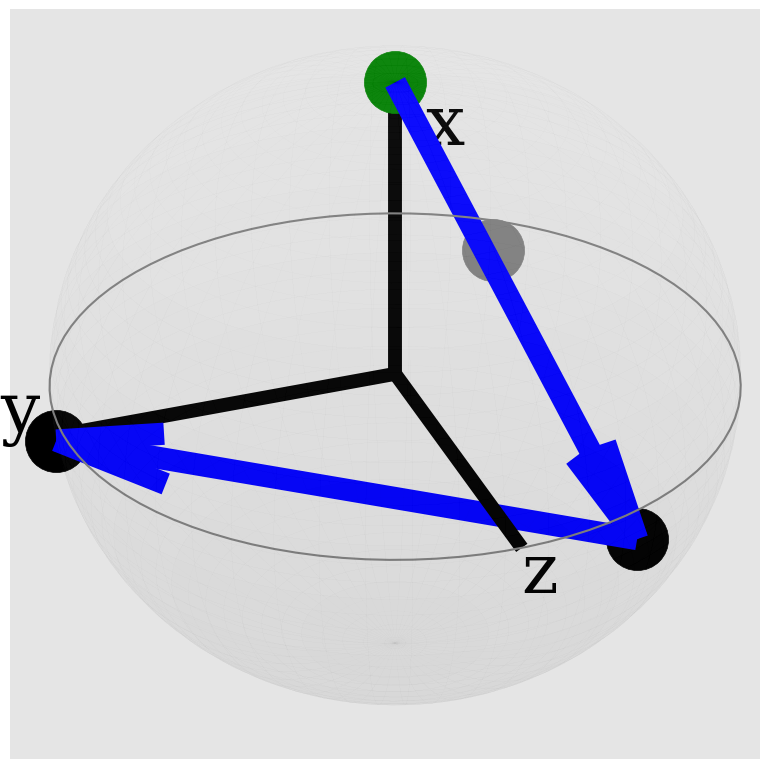

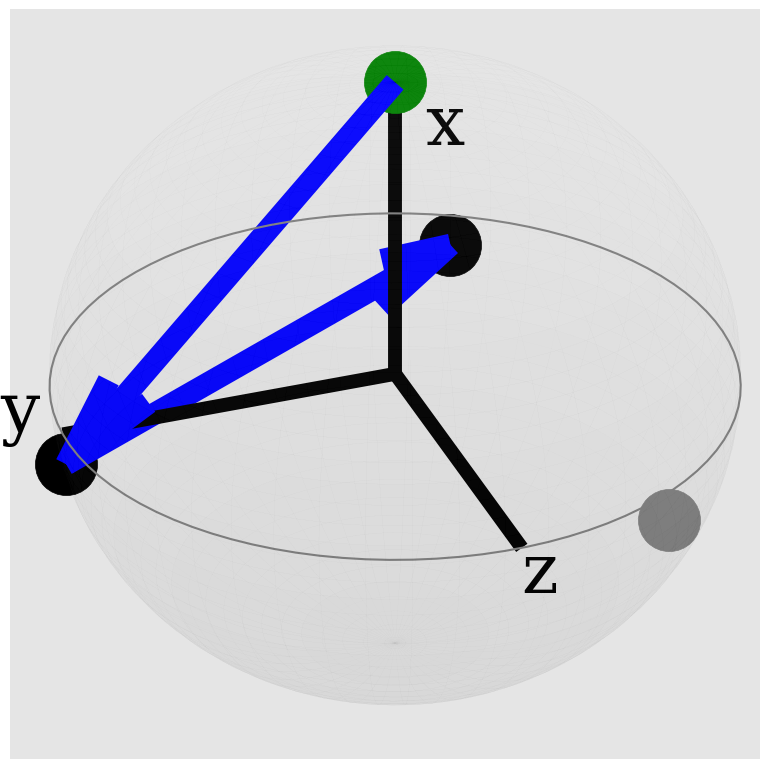

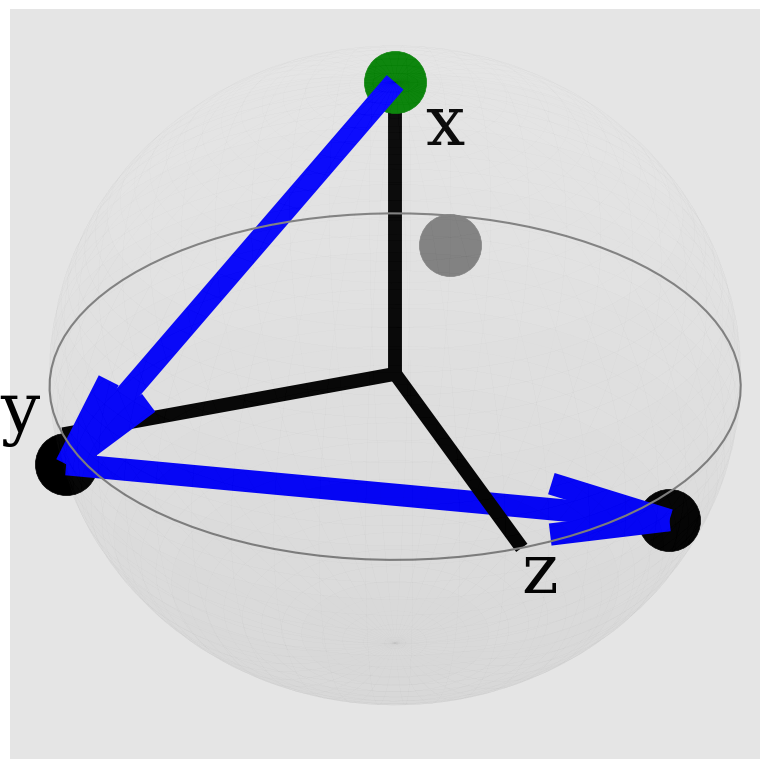

In [44]:
if __name__ == "__main__":
    from torch_geometric.datasets import QM9
    from scipy.spatial.transform import Rotation as R
   
    qm9 = QM9(root='../datasets/qm9-2.4.0/')
    frame = Frame()
    for i,data in enumerate(qm9):
        k=1
        if i>k:
            break
        elif i<k:
            continue
        else:
            random_rotation = R.random().as_matrix()
            random_translation = np.random.rand(3)
            point_cloud = data.pos - data.pos.mean(dim=0)
            point_cloud = (random_rotation@(point_cloud).numpy().T).T
            cat_data = data.z.numpy()
            aligned_data = frame.get_frame(point_cloud, cat_data)
            # cat_data = data.z.numpy()
            # aligned_data = frame.get_frame(data.pos.numpy(), cat_data)
    pass